In [ ]:
%run utilities.ipynb 
load_standard_packages()
change_wordir()
import json

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.58.0


In [2]:
analysis = "PIRKs"

colors, colours = colourblind_palette("own")

#model = "cyclic_2021"
#model = "new_PSI"
#model = "new_PSII"
#model = "new_b6f"
model = "latest_dev"

m = load_model(model)


succesfully loaded latest_dev :D


In [4]:
y0 = get_stst_y0(m, pfd=100)

In [6]:
protocol_file = "protocols/PIRK_DMK_TB3.json"
#protocol_file = "protocols/PIRK.json"

In [7]:
with open(protocol_file, 'r') as f:
    protocol = f.read()

# Parse it safely (despite ugly format)
protocol_json = json.loads(protocol)

In [8]:
"""
protocol_interpreter.py

A Python module to parse and execute custom measurement protocols described in JSON.

Features and assumptions:
- Resolves variable references (@nX:Y, @sX) and length tokens (#lX).
- Supports autogain definitions (a_bX, a_dX), ignoring non-actinic LEDs (>700 nm).
- Filters to only execute illumination-driving steps (pre_illumination or pulses).
- Honors 'do_once' flags: such steps run only on the first repeat.
- Converts timing units: pre-illumination in ms → seconds; pulse gaps in µs → seconds.
- Aggregates non-pulsed background lighting; pulses themselves are considered non-actinic.

Limitations:
- Does not model individual pulses; only simulates the cumulative post-pulse relaxation.
- Assumes Simulator.simulate(t) advances simulation to absolute time t (not delta).
- Wavelength weighting is fixed; users must supply action-spectrum adjustments externally.
- Environmental, PAM, SPAD, battery-check steps are ignored.

Usage:
    from protocol_interpreter import ProtocolInterpreter

    pi = ProtocolInterpreter(json_spec)
    sim = Simulator(model)
    sim.initialise(y0)
    concentrations, fluxes = pi.run(sim)
"""

import json
from typing import Any, Dict, List, Union

class ProtocolInterpreter:
    """
    Interpreter for experimental protocols.
    """
    # LED emission peaks (nm) for indices 1..10
    LED_TABLE: Dict[int, Dict[str, Any]] = {
        1: {'nm': 530}, 2: {'nm': 655}, 3: {'nm': 590}, 4: {'nm': 448}, 5: {'nm': 950},
        6: {'nm': 950}, 7: {'nm': 655}, 8: {'nm': 850}, 9: {'nm': 730}, 10: {'nm': 820}
    }
    # Above this threshold, LEDs are assumed non-actinic and ignored
    NON_ACTINIC_THRESHOLD_NM = 700

    def __init__(self, spec: Union[str, List[Dict[str, Any]]]):
        """
        Load protocol JSON (string or parsed list), extract settings.
        """
        print("Initializing ProtocolInterpreter...")
        if isinstance(spec, str):
            print("Loading JSON from string...")
            spec = json.loads(spec)

        # The top-level protocol is the first element
        self.spec = spec[0]
        self.vars = self.spec.get("v_arrays", [])  # variable arrays for references
        print(f"Variable arrays: {self.vars}")

        # Global share factor (not used but stored)
        self.share = self.spec.get("share", 1)
        print(f"Share: {self.share}")

        # Determine repeat count (supports #lX format)
        raw_repeats = self.spec.get("set_repeats")
        print(f"Raw repeats token: {raw_repeats}")
        self.repeats = self._resolve(raw_repeats, 0)
        print(f"Repeats resolved to: {self.repeats}")

        # Parse autogain definitions and collect only illumination steps
        self.autogains: Dict[int, Dict[str, Any]] = {}
        raw_steps = self.spec.get("_protocol_set_", [])
        self.steps: List[Dict[str, Any]] = []
        for step in raw_steps:
            if 'autogain' in step:
                # Store gain settings by index
                for entry in step['autogain']:
                    idx, led, det, dur, target = entry
                    self.autogains[idx] = {'led': led, 'duration': dur, 'target': target}
                    print(f"Registered autogain idx={idx}: LED={led}, duration={dur}, target={target}")
            elif 'pre_illumination' in step or 'pulses' in step:
                # Only include steps that actually change light
                self.steps.append(step)
        print(f"Protocol steps loaded: {len(self.steps)} usable steps.")

    def _parse_reference(self, token: Any, iteration: int = 0) -> Any:
        """
        Resolve a single token:
        - a_bX / a_dX: autogain brightness/duration
        - #lX: length of variable array X
        - @nX:Y, @sX: variable lookup
        """
        # Autogain brightness or duration
        if isinstance(token, str) and token.startswith('a_'):
            part, idx = token[2], int(token[3:])
            ag = self.autogains[idx]
            led_nm = self.LED_TABLE.get(ag['led'], {}).get('nm', 0)
            if part == 'b':
                # ignore non-actinic gains
                return 0 if led_nm > ProtocolInterpreter.NON_ACTINIC_THRESHOLD_NM else ag['target']
            return ag['duration']

        # Length reference
        if isinstance(token, str) and token.startswith('#l'):
            return len(self.vars[int(token[2:])])

                # Length reference
        if isinstance(token, str) and token.startswith('#l'):
            return len(self.vars[int(token[2:])])

        # Autogenerated variable references:
        # @sX: set-repeat index lookup  (# set repeat)
        # @pX: protocol-repeat index lookup  (# protocol repeat)
        # @nX:Y: fixed numeric lookup  (# single value)
        if isinstance(token, str) and token.startswith('@'):
            kind = token[1]
            parts = token[2:].split(':')
            arr_idx = int(parts[0])
            if kind == 's':  # set repeat
                return self.vars[arr_idx][iteration]
            if kind == 'n':  # single numeric value
                return self.vars[arr_idx][int(parts[1])]

        # Literal value
        return token

    def _resolve(self, item: Any, iteration: int) -> Any:
        """
        Recursively resolve lists of tokens.
        """
        if isinstance(item, list):
            return [self._resolve(sub, iteration) for sub in item]
        return self._parse_reference(item, iteration)

    def expand_step(self, step: Dict[str, Any], iteration: int) -> Dict[str, Any]:
        """
        Expand all references in a protocol step.
        """
        print(f"Expanding '{step.get('label', 'no_label')}' @ iter {iteration}")
        expanded: Dict[str, Any] = {}
        for k, v in step.items():
            expanded[k] = self._resolve(v, iteration)
            print(f" -> {k}: {expanded[k]}")
        return expanded

    def build_sequence(self) -> List[Dict[str, Any]]:
        """
        Create the full sequence of expanded steps, honoring do_once flags.
        """
        print("Building sequence...")
        seq: List[Dict[str, Any]] = []
        for i in range(self.repeats):
            print(f" Repeat {i+1}/{self.repeats}")
            for step in self.steps:
                # skip steps with do_once after first iteration
                if i > 0 and step.get('do_once'):
                    continue
                seq.append(self.expand_step(step, i))
        print(f"Total steps: {len(seq)}")
        return seq

    def run(self, sim: Any):
        """
        Execute the protocol on a simulator instance.

        Assumes Simulator.simulate(t) advances to absolute time t (s).
        Pulsed lights are ignored for actinic effect; only background is simulated.
        """
        print("Running protocol...")
        current_time_s = 0.0  # simulation clock in seconds

        steps_sequence = self.build_sequence()
        total_steps = len(steps_sequence)

        for idx, step in enumerate(steps_sequence, 1):
            print(f"Step {idx}/{total_steps}: {step.get('label', '')}")

            # Pre-illumination: convert milliseconds to seconds
            if 'pre_illumination' in step:
                _, pfd, dur_ms = step['pre_illumination']
                duration_s = dur_ms * 1e-3
                print(f" Pre-illum PFD={pfd}, duration={duration_s}s")
                sim.update_parameter('pfd', pfd)
                sim.simulate(current_time_s + duration_s)
                current_time_s += duration_s
                print(f" Simulation time now at {current_time_s}s")

            # Post-pulse relaxation: simulate only background
            if 'pulses' in step:
                background_levels = step.get('nonpulsed_lights_brightness', [])
                pulse_intervals_us = step['pulse_distance']

                for j, pulse_count in enumerate(step['pulses']):
                    # Calculate total interval Δt: number of pulses × pulse distance per pulse
                    delta_t = pulse_count * pulse_intervals_us[j] * 1e-6  # seconds
                    # Background brightness sum
                    background_brightness = sum(background_levels[j]) if j < len(background_levels) else 0
                    print(f" Δt (interval) after {pulse_count} pulses: background={background_brightness}, Δt={delta_t}s")
                    sim.update_parameter('pfd', background_brightness)
                    sim.simulate(current_time_s + delta_t)
                    current_time_s += delta_t
                    print(f" Simulation time now at {current_time_s}s")

        print("Completed run.")
        return sim.get_full_results_df(), sim.get_fluxes_df()


In [9]:
pi = ProtocolInterpreter(protocol_json)

s = Simulator(m)
s.initialise(y0)

c, v = pi.run(s)

Initializing ProtocolInterpreter...
Variable arrays: [[100, 500], [500, 1000, 2000, 1, 30, 15, 20, 40, 80], [8000, 6000, 4000], [1000, 4000], [800]]
Share: 1
Raw repeats token: #l0
Repeats resolved to: 2
Registered autogain idx=1: LED=1, duration=20, target=50000
Registered autogain idx=0: LED=10, duration=20, target=50000
Protocol steps loaded: 2 usable steps.
Running protocol...
Building sequence...
 Repeat 1/2
Expanding 'PIRK' @ iter 0
 -> label: PIRK
 -> e_time: 1
 -> pre_illumination: [2, 100, 10000]
 -> pulses: [30, 1, 30, 1, 30, 1, 15, 1, 15, 1, 20, 1, 40, 1, 40, 1, 15]
 -> nonpulsed_lights: [[2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4]]
 -> pulse_distance: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 -> nonpulsed_lights_brightness: [[100, 0], [100, 500], [100, 0], [100, 1000], [100, 0], [100, 2000], [0, 0], [0, 2000], [0, 0], [0, 2

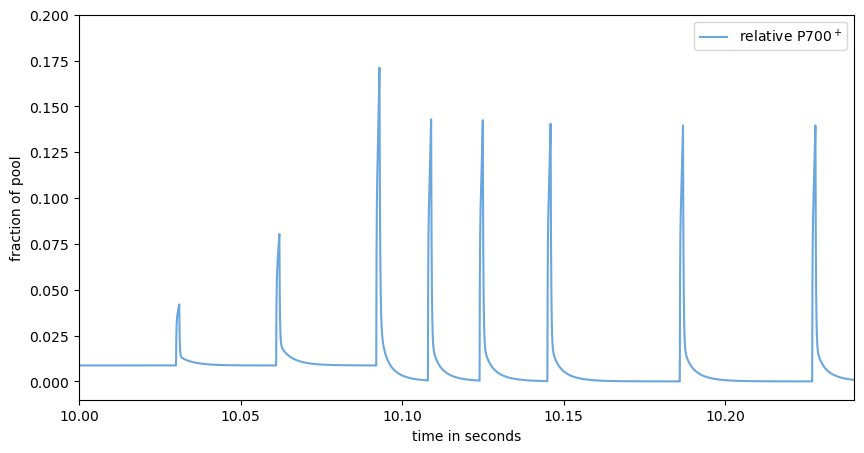

In [11]:
# P700

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["rel_P700+"], label="relative P700$^+$", color=colors[0])
ax.set(xlim=(10, 10.24),
    ylim=(-0.01,0.2),
    xlabel=("time in seconds"),
    ylabel=("fraction of pool"))

# for start, end in dark_periods:
#     ax.axvspan(start, end, color='grey', alpha=0.5, lw=0)

ax.legend()
plt.show()

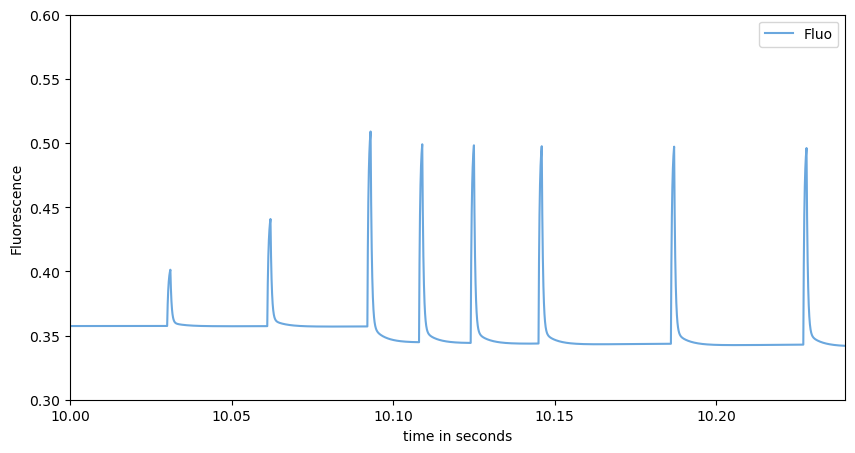

In [19]:
# Fluorescence

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["Fluo"]/max(c["Fluo"]), label="Fluo", color=colors[0])
ax.set(ylabel=("Fluorescence"))
ax.set(xlim=(10, 10.24),
    ylim=(0.3,0.6),
    xlabel=("time in seconds"),
    ylabel=("Fluorescence"))

# for start, end in dark_periods:
#     ax.axvspan(start, end, color='grey', alpha=0.5, lw=0)

ax.legend()
plt.show()

# PRETTYFY JSON SCRIPTS

In [13]:
# because for some reason json inserts newline characters EVERYWHERE, here is a code to clean that up

#ugly_protocol = './protocols/name.json'
#ugly_protocol = './protocols/PIRK.json'
ugly_protocol = './protocols/PIRK_DMK_TB3.json'

import json

def dumps_inline_arrays(obj, indent=0):
    pad = ' ' * indent
    if isinstance(obj, dict):
        items = []
        for k, v in obj.items():
            val_str = dumps_inline_arrays(v, indent + 2)
            items.append(f'{pad}  "{k}": {val_str}')
        return '{\n' + ',\n'.join(items) + f'\n{pad}}}'
    elif isinstance(obj, list):
        # Always format list on one line
        inner = ', '.join(dumps_inline_arrays(x, 0) for x in obj)
        return f'[{inner}]'
    elif isinstance(obj, str):
        return json.dumps(obj)  # handles escaping
    else:
        return str(obj)

# --- Load and format ---
with open(ugly_protocol, 'r') as f:
    data = json.load(f)

pretty = dumps_inline_arrays(data)
print(pretty)


[{
  "share": 1,
  "v_arrays": [[100, 500], [500, 1000, 2000, 1, 30, 15, 20, 40, 80], [8000, 6000, 4000], [1000, 4000], [800]],
  "set_repeats": "#l0",
  "_protocol_set_": [{
  "check_battery": 1,
  "label": "no_leaf_baseline",
  "par_led_start_on_open": 2,
  "averages": 1,
  "do_once": 1
}, {
  "par_led_start_on_close": 2,
  "bleed_correction": 1,
  "do_once": 1
}, {
  "label": "env",
  "environmental": [["light_intensity"], ["temperature_humidity_pressure"], ["temperature_humidity_pressure2"], ["contactless_temp"], ["compass_and_angle"]],
  "autogain": [[1, 1, 3, 20, 50000], [0, 10, 1, 20, 50000]],
  "do_once": 1,
  "e_time": 1
}, {
  "label": "PIRK",
  "e_time": 1,
  "pre_illumination": [2, "@s0", 10000],
  "pulses": ["@n1:4", "@n1:3", "@n1:4", "@n1:3", "@n1:4", "@n1:3", "@n1:5", "@n1:3", "@n1:5", "@n1:3", "@n1:6", "@n1:3", "@n1:7", "@n1:3", "@n1:7", "@n1:3", "@n1:5"],
  "nonpulsed_lights": [[2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 4], [2, 